In [12]:
import numpy as np
import torch
import torch.nn as nn

In [13]:
def segment_features(features, segment_frames=44, hop_frames=1):
    # Number of feature frames in the file
    num_frames = features.shape[1]
    
    # Calculate the number of segments we can extract
    num_segments = 1 + (num_frames - segment_frames) // hop_frames
    
    # Prepare an array to store segments
    segments = []
    
    # Extract segments using a sliding window
    for i in range(num_segments):
        start_frame = i * hop_frames
        end_frame = start_frame + segment_frames
        segment = features[:, start_frame:end_frame]
        segments.append(segment)
        
    return np.array(segments)

In [14]:
test_data_1 = np.load('../../Data/scene_analysis/2_Florian_Heizung_aus.npy')
test_data_2 = np.load('../../Data/scene_analysis/3_Verena_Staubsauger_an_Alarm_an.npy')
test_data_3 = np.load('../../Data/scene_analysis/5_Lukas_Staubsauger_an_Licht_aus.npy')
test_data_4 = np.load('../../Data/scene_analysis/6_Deepak_Radio_aus_Licht_aus.npy')

print(f"Florian Heizung aus (Scene 1): {test_data_1.shape} "
      f"\nVerena Staubsauger an Alarm an (Scene 2): {test_data_2.shape} "
      f"\nLukas Staubsauger an Licht aus (Scene 3): {test_data_3.shape} "
      f"\nDeepak Radio aus Licht aus (Scene 4): {test_data_4.shape}")

Florian Heizung aus (Scene 1): (1, 175, 854) 
Verena Staubsauger an Alarm an (Scene 2): (1, 175, 762) 
Lukas Staubsauger an Licht aus (Scene 3): (1, 175, 292) 
Deepak Radio aus Licht aus (Scene 4): (1, 175, 243)


In [4]:
test_data_1.shape

(1, 175, 854)

In [51]:
from model_architectures import EnhancedAudioCNN

def load_model(model_path, device='cpu'):
    checkpoint = torch.load(model_path, map_location=device)
    model = EnhancedAudioCNN()
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    model.to(device)
    return model

#model_path = 'models/EnhancedAudioCNN_1.pth'
model_path = 'data_leakage_fixed.pth'
use_mps = torch.backends.mps.is_available()
device = torch.device("mps" if use_mps else "cpu")
# Load the model
model = load_model(model_path, device=device)

seg_1 = segment_features(test_data_1[0])
seg_2 = segment_features(test_data_2[0])
seg_3 = segment_features(test_data_3[0])
seg_4 = segment_features(test_data_4[0])

"""seg_1 = np.concatenate((seg_1[:, :22, :], seg_1[:, 87:, :]), axis=1)
seg_2 = np.concatenate((seg_2[:, :22, :], seg_2[:, 87:, :]), axis=1)
seg_3 = np.concatenate((seg_3[:, :22, :], seg_3[:, 87:, :]), axis=1)
seg_4 = np.concatenate((seg_4[:, :22, :], seg_4[:, 87:, :]), axis=1)"""

# Assume segments are already loaded and segmented from the previous step
segments_1 = torch.tensor(seg_1, dtype=torch.float32).to(device)
segments_2 = torch.tensor(seg_2, dtype=torch.float32).to(device)
segments_3 = torch.tensor(seg_3, dtype=torch.float32).to(device)
segments_4 = torch.tensor(seg_4, dtype=torch.float32).to(device)

segments_1 = segments_1.unsqueeze(1)
segments_2 = segments_2.unsqueeze(1)
segments_3 = segments_3.unsqueeze(1)
segments_4 = segments_4.unsqueeze(1)

# Apply the model to each segment
results = []
for segment_tensor in segments_3:
    # Each tensor in segments is (1, feature_dim, segment_frames), which should match the expected input shape of your model
    segment_tensor = segment_tensor.unsqueeze(0)
    
    with torch.no_grad():
        output = model(segment_tensor)
        results.append(torch.softmax(output, dim=1).detach().cpu().numpy())

In [6]:
words = []
for i, result in enumerate(results):
    if max(result[0]) > 0.5:
        words.append([i, result])
len(words)

283

In [6]:
segments_1.shape

torch.Size([811, 1, 175, 44])

In [52]:
# Dictionary mapping from index to class
class_mapping = {
    0: 'Alarm',
    1: 'Brötchen',
    2: 'Fernseher',
    3: 'Haus',
    4: 'Heizung',
    5: 'Leitung',
    6: 'Licht',
    7: 'Lüftung',
    8: 'Ofen',
    9: 'Radio',
    10: 'Schraube',
    11: 'Spiegel',
    12: 'Staubsauger',
    13: 'an',
    14: 'aus',
    15: 'kann',
    16: 'nicht',
    17: 'offen',
    18: 'warm',
    19: 'wunderbar'
}

# Initialize a dictionary to hold prediction counts
prediction_counts = {name: 0 for name in class_mapping.values()}
words_position = []
# Process each result in the results list
for i, result in enumerate(results):
    probabilities = np.array(result[0])
    if max(probabilities) > 0.9:
        predicted_index = np.argmax(probabilities)
        predicted_class = class_mapping[predicted_index]
        prediction_counts[predicted_class] += 1
        words_position.append([i, predicted_class])
sum_of_counts = sum(prediction_counts.values())
# Now print the counts of each predicted class
for class_name, count in prediction_counts.items():
    if count>0:
        print(f"{class_name}: {count}")
    
#print(sum_of_counts)

Fernseher: 1
Licht: 6
Staubsauger: 23
an: 8
aus: 9


In [22]:
segments_1.cpu().numpy().shape

(811, 1, 175, 44)

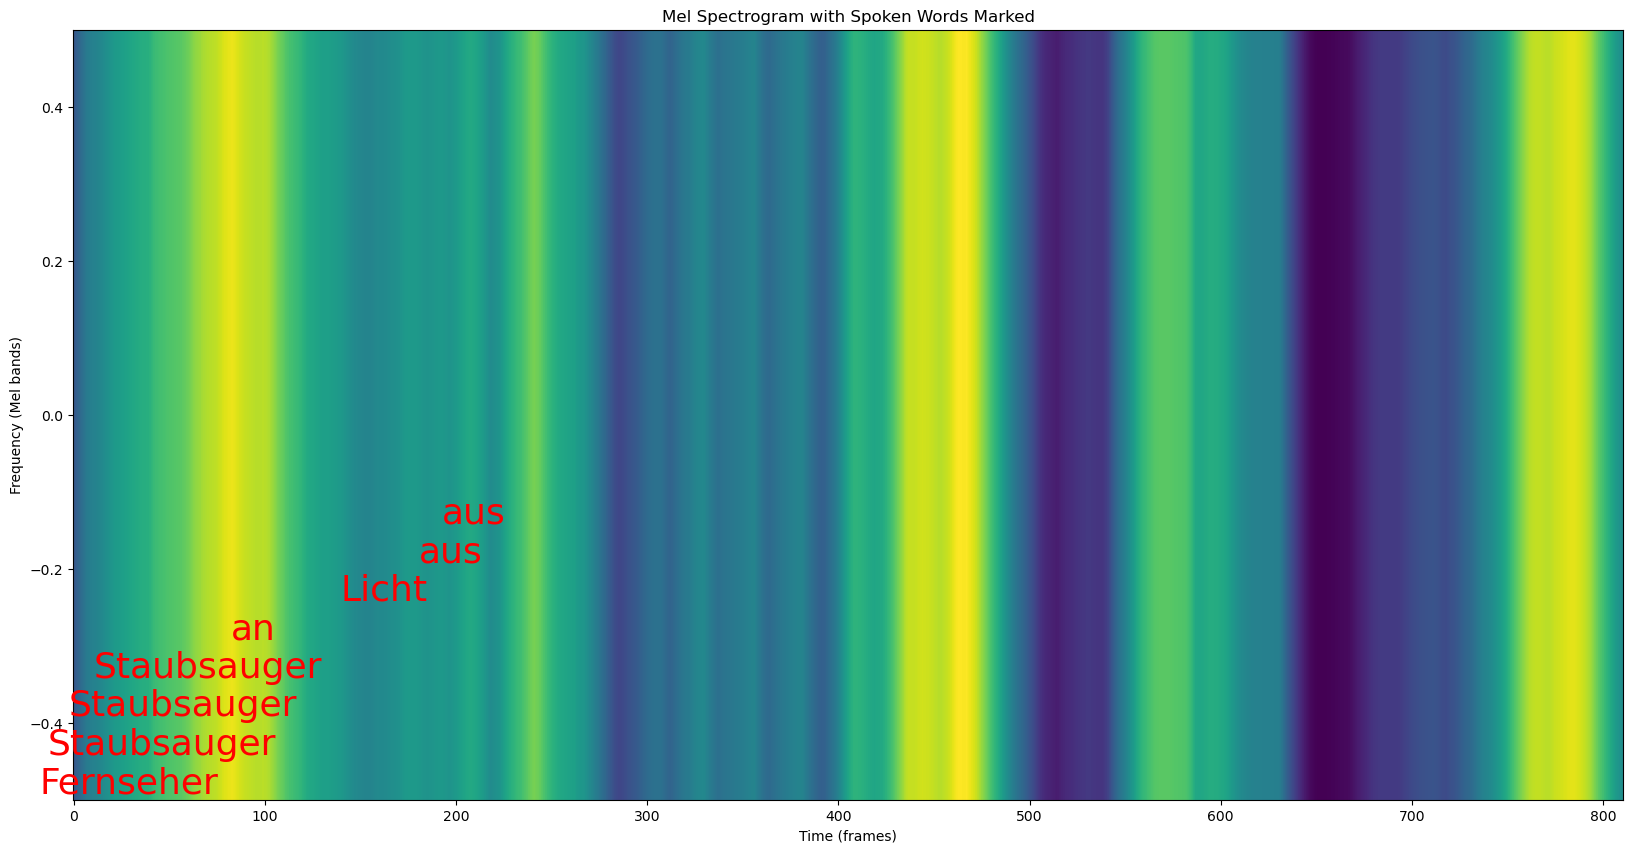

In [53]:
import matplotlib.pyplot as plt
melspect_indices = list(range(12, 76))  # melspect_0 to melspect_63

# Extract Mel spectrogram data
melspect_data = segments_1.cpu().numpy()[:, :, melspect_indices, :]

# Average across segments to create a single spectrogram (if needed)
# Here, averaging over the 0-axis (segments) to get a (frames, features) shape
#print(melspect_data.shape)
spectrogram = np.mean(melspect_data, axis=2)
spectrogram = np.mean(spectrogram, axis=2)
# Transpose to get the correct shape for plotting (features, frames)
spectrogram = (spectrogram - np.min(spectrogram)) / (np.max(spectrogram) - np.min(spectrogram))
spectrogram = spectrogram.T
#spectrogram = spectrogram[:, ::downsample_factor]
# Plotting the spectrogram
plt.figure(figsize=(20, 10))
plt.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')
plt.title('Mel Spectrogram with Spoken Words Marked')
plt.xlabel('Time (frames)')
plt.ylabel('Frequency (Mel bands)')

# Mark the spoken words on the spectrogram
predictions = words_position
# Add text annotations
"""
for idx, word in predictions:
    print(idx)
    plt.text(idx, -0.5, word, color='red', fontsize=12, ha='center', va='bottom')"""
unique_predictions = []
last_word = None
range_limit = 10  # Define a range to skip close duplicate words

for idx, word in predictions:
    if last_word is None or word != last_word or (unique_predictions and idx - unique_predictions[-1][0] > range_limit):
        unique_predictions.append((idx, word))
        last_word = word

# Add text annotations
position = -0.5
for idx, word in unique_predictions:
    plt.text(idx, position, word, color='red', fontsize=26, ha='center', va='bottom')
    position += 0.05

plt.show()

In [45]:
def compute_cost(predictions, annotations):
    cost = 0
    for pred in predictions:
        if pred['type'] == 'true_positive':
            cost -= 1
        elif pred['type'] == 'false_negative':
            cost += 0.5
        elif pred['type'] == 'false_positive':
            command = pred['command']
            if command in ["Fernseher an", "Fernseher aus", "Licht an", "Licht aus", "Radio an", "Radio aus", "Staubsauger an", "Staubsauger aus"]:
                cost += 2
            elif command in ["Heizung an", "Heizung aus", "Lüftung an", "Lüftung aus"]:
                cost += 3
            elif command in ["Ofen an", "Ofen aus", "Alarm an", "Alarm aus"]:
                cost += 4
        elif pred['type'] == 'cross_trigger':
            if pred['correct_device']:
                cost += 0.1
            else:
                cost += 1
    return cost
